# E-commerce 데이터 분석

지금까지 python 코드로 데이터 베이스에 데이터를 집어넣고, SQL로 원하는 데이터를 읽어와서 시각화하는 방법을 배워봤습니다.  
이번 시간에는 실제 브라질의 이커머스 기업의 데이터를 가지고 분석 작업을 수행해보겠습니다.  

## 데이터 셋 준비

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

olist라는 브라질의 이커머스 기업이 자신들의 데이터 베이스를 공개하였습니다. 

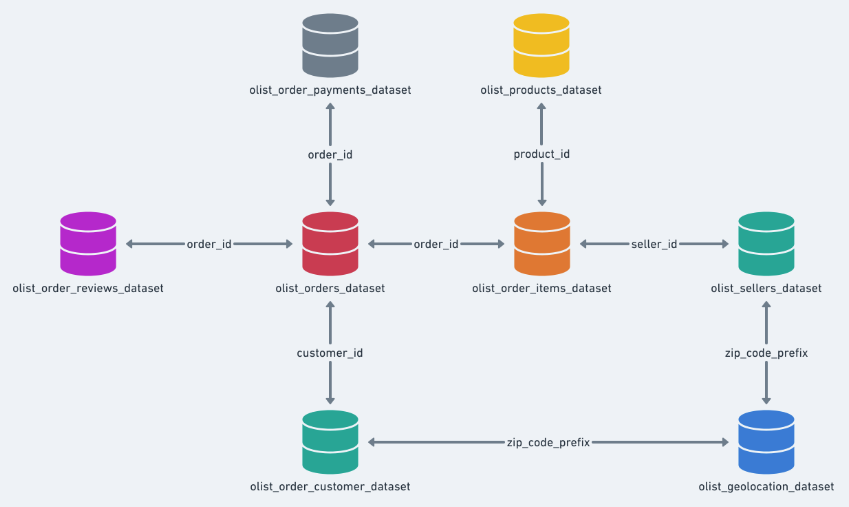

총 8개의 테이블로 이루어져 있으며, 수백만건의 이커머스 주문 데이터를 담고 있습니다.  
전체 데이터 셋의 구성과 관계를 파악하지는 않을거고, 그 중에서 일부만 가져와서 실습을 해보겠습니다.

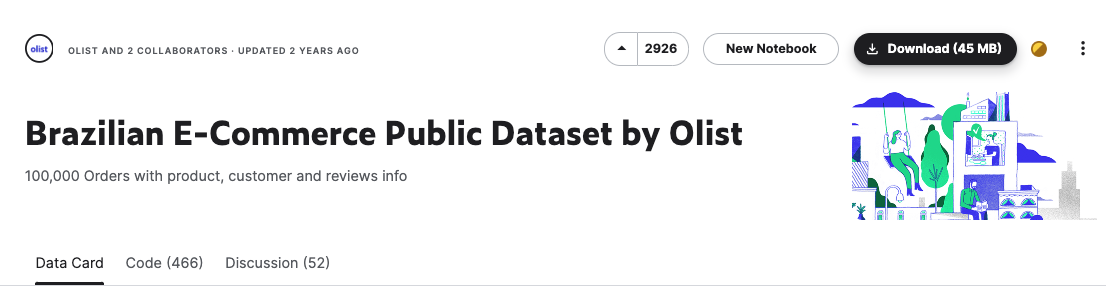

먼저 kaggle로 이동해서 데이터 셋을 다운로드 받아주세요.  

그 다음, 압축을 풀어주면 각 테이블 별로 CSV 파일이 보일겁니다.

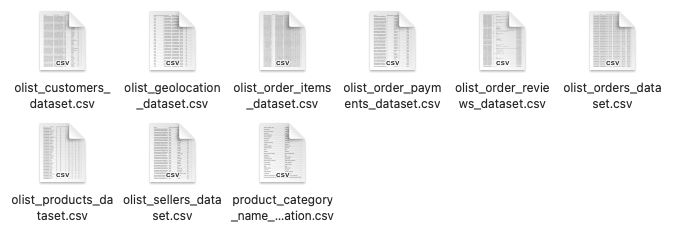

이 파일들에서 우리는 olist_orders_dataset.csv 파일과 olist_order_payments_dataset.csv 두 개의 파일을 사용할 겁니다.  
data 폴더 아래에 위치시킨 뒤, 각각 olist_orders.csv와 olist_order_payments.csv로 이름을 바꿔주겠습니다.

## 데이터 셋 살펴보기

각 파일들을 열어서 실제로 어떻게 생겼는지 확인해보겠습니다.  
olist_orders_dataset 파일은 주문 데이터가 저장되어 있습니다. 
- order_id: 주문 id
- customer_id: 고객 id
- order_status: 배송 상태
- order_purchase_timestamp: 결제 일자
- order_approved_at: 주문 승인 일자
- order_delivered_carrier_date: 물류센터 도착 일자
- order_delivered_customer_date: 고객에게 전달 완료 일자
- order_estimated_delivery_date: 예상 도착 일자

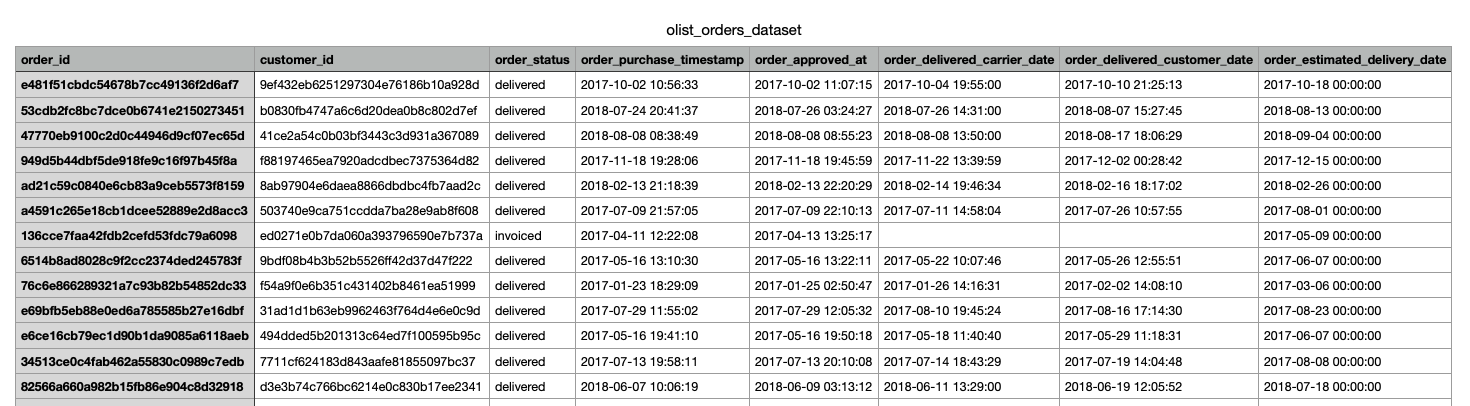

다음으로 olist_order_payments_dataset에는 각 주문별로 결제와 관련된 데이터가 저장되어 있습니다.  
- order_id: 주문 id
- payment_sequential: 결제 일련 번호 (하나의 주문에 여러개의 결제 수단이 선택될 수 있음. 각 결제 수단별 일련 번호)
- payment_type: 결제 유형
- payment_installments: 할부 횟수
- payment_value: 결제 금액

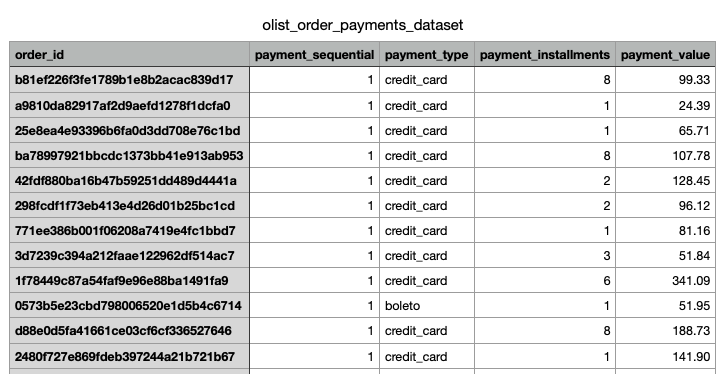

## DB 테이블 만들기

먼저 데이터 베이스에 olist_orders와 olist_order_payments 테이블을 만들어보겠습니다.  
행의 일련번호를 나타내는 id라는 컬럼을 하나 추가했고, 이를 PK로 지정했습니다.  
그리고 AI에 체크를 해줬는데, 이는 auto_increment의 약자로 행을 하나 추가할 때마다 id 값이 자동으로 1씩 증가하도록 설정한 겁니다.

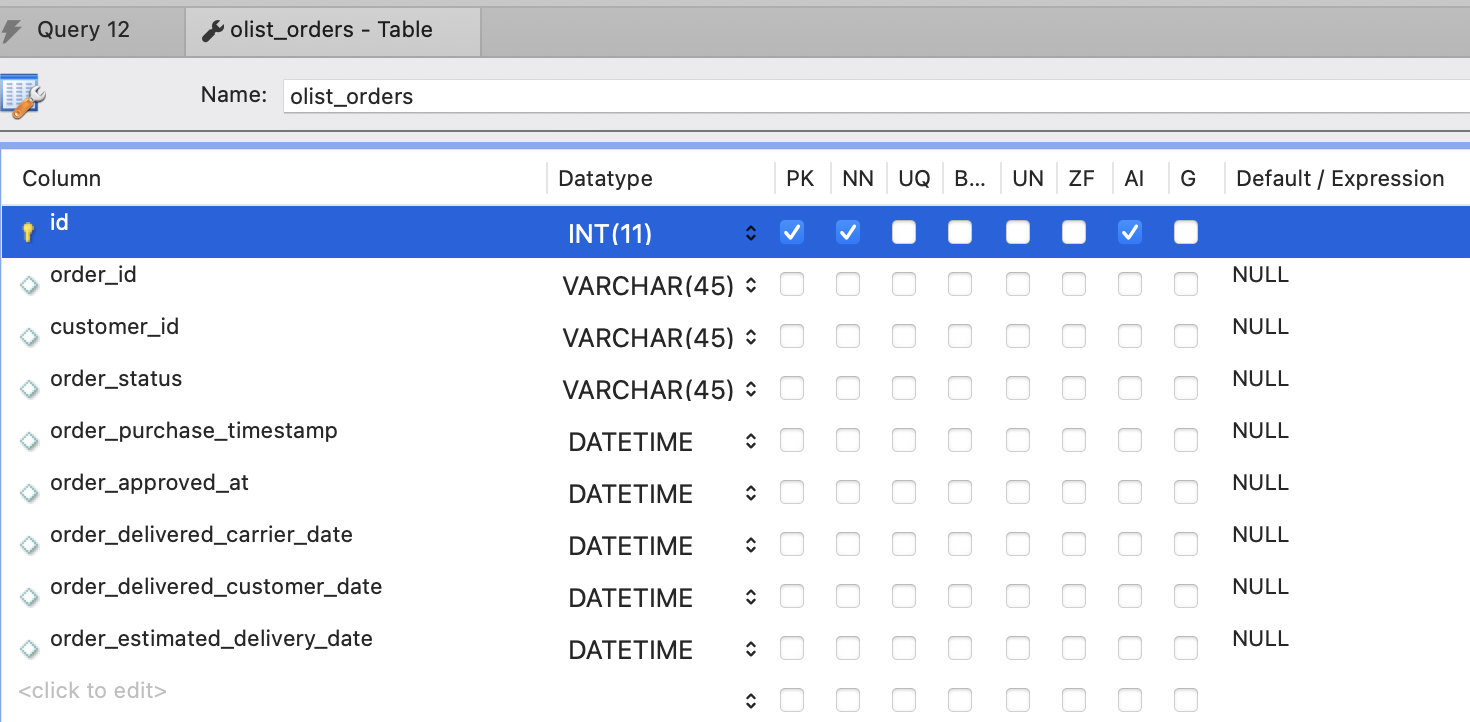

olist_order_payments 테이블도 만들어줍니다. 이 때 id 컬럼 추가된 걸 신경써줘야 합니다.

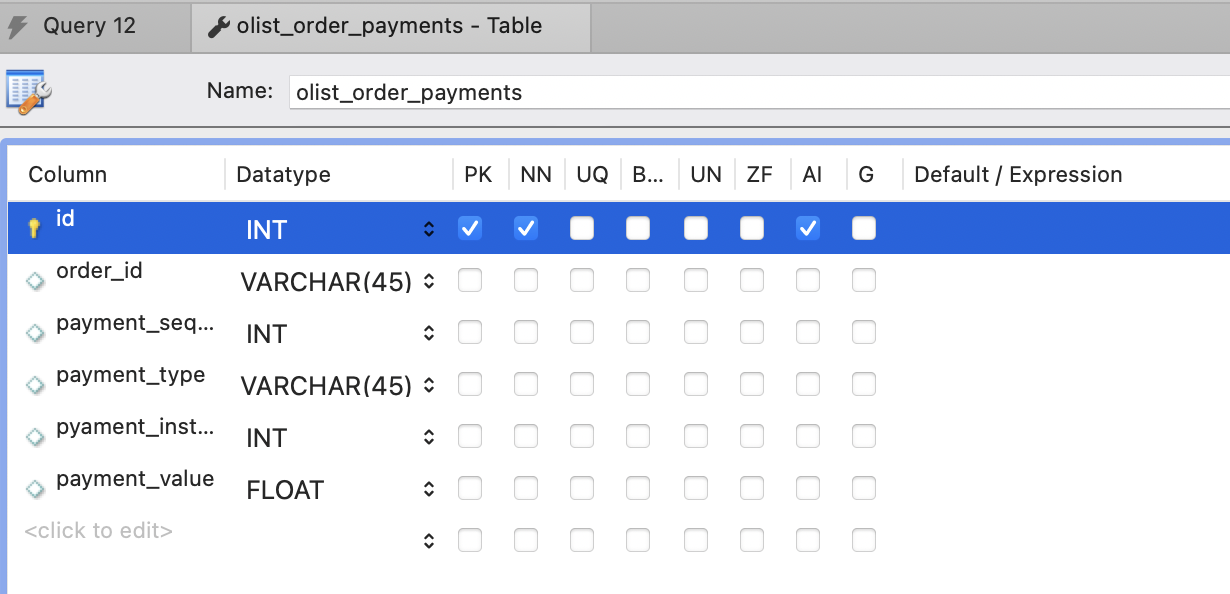

## 데이터 쓰기

이전 시간에 작성했던 bulk_write 함수를 복사해와서 SQL문을 파라미터로 전달받도록 살짝 수정하겠습니다.  
각 테이블 별로 SQL문을 다르게 작성해주기 위함입니다.

In [25]:
import pymysql 

def get_connection():
    conn = pymysql.connect(
        host="127.0.0.1",
        user="root",
        password="1234",
        database="multicampus",
    )
    return conn

In [26]:
conn = get_connection()

In [3]:
import csv

def _execute_insert(sql, buffer):
    with conn.cursor() as cursor:
        result = cursor.executemany(sql, buffer)
        conn.commit()
        print("write:", result)
        
def bulk_write(sql, data_file_path, batchsize=100):
    with open(data_file_path) as fr:
        reader = csv.reader(fr)
        buffer = []
        for i, row in enumerate(reader):
            if i == 0:
                continue
            row = [x if x else None for x in row]
            buffer.append(row)
            if len(buffer) == batchsize:
                _execute_insert(sql, buffer)
                buffer = []
        if buffer:
            _execute_insert(sql, buffer)

그 다음, 각 테이블 별로 sql 문을 작성해준 뒤, bulk_write를 수행해보겠습니다.  
CSV 파일에는 없는 id 컬럼을 새로 추가했기 때문에 데이터를 집어넣고자 하는 컬럼을 명시해줘야 합니다.

In [10]:
write_orders_sql = """
INSERT IGNORE INTO
    olist_orders(
        order_id,
        customer_id,
        order_status,
        order_purchase_timestamp,
        order_approved_at,
        order_delivered_carrier_date,
        order_delivered_customer_date,
        order_estimated_delivery_date
    )
VALUES
    (%s, %s, %s, %s, %s, %s, %s, %s)
"""

In [11]:
bulk_write(write_orders_sql, "./data/olist_orders.csv", batchsize=10000)

write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 9441


In [29]:
write_payments_sql = """
INSERT IGNORE INTO
    olist_order_payments(
        order_id,
        payment_sequential,
        payment_type,
        payment_installments,
        payment_value
    )
VALUES
    (%s, %s, %s, %s, %s)
"""

In [30]:
bulk_write(write_payments_sql, "./data/olist_order_payments.csv", batchsize=10000)

write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 10000
write: 3886


## 데이터 확인

각 테이블 별로 약 10만건의 데이터가 잘 들어갔는지 확인해보겠습니다.

In [31]:
import pandas as pd

def read_data(sql):
    return pd.read_sql(sql, conn)

In [34]:
count_olist_orders = """
SELECT
    COUNT(*) as cnt
FROM
    olist_order_payments
"""

In [35]:
read_data(count_olist_orders)

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_76121/1875548506.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


,cnt
0,103886


## 인덱스 생성하기

주문이 이루어진 시간은 olist_orders 테이블에, 주문 결제 금액은 olist_order_payments 테이블에 나뉘어 있습니다.  
만약 일별 매출 추이를 집계하고 싶다면 어떻게 할 수 있을까요?  
바로 두 테이블을 조인한 다음, 주문이 이루어진 날짜 별로 GROUP BY를 해서 SUM을 해주는 겁니다.  

그런데 각 테이블별로 레코드가 10만개씩 들어있습니다.  
이를 그대로 조인하게 되면, 연산이 너무 많아서 오랜 시간이 걸립니다.
이럴 때 활용할 수 있는 것이 인덱스입니다.  
olist_order_payments 테이블의 order_id 컬럼에 인덱스를 걸어주면 조인 연산이 획기적으로 빨라집니다.


먼저 커넥션이 열려있으면 인덱스 생성 작업이 진행되지 않으므로 커넥션을 종료하겠습니다.

In [6]:
conn.close()

workbench 상에서 인덱스를 생성하는 SQL문을 실행하겠습니다.

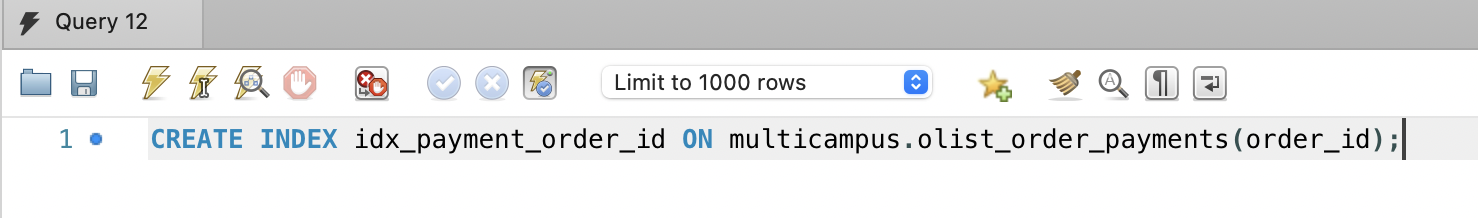

In [36]:
conn.close()

그 다음, olist_orders 테이블에서 2017년 1월 1일부터 2017년 1월 31일까지 데이터만 읽어오도록 SQL문을 작성하고 실행해보겠습니다. 

In [41]:
read_sql = """
SELECT
    order_id,
    order_purchase_timestamp
FROM
    olist_orders
WHERE
    order_purchase_timestamp >= "2017-01-01"
    AND order_purchase_timestamp < "2017-02-01"
ORDER BY
    order_purchase_timestamp
"""

In [42]:
conn = get_connection()

In [43]:
df = read_data(read_sql)
df

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_76121/1875548506.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


,order_id,order_purchase_timestamp
0,ec7a019261fce44180373d45b442d78f,2017-01-05 11:56:06
1,b95a0a8bd30aece4e94e81f0591249d8,2017-01-05 12:01:20
2,38bcb524e1c38c2c1b60600a80fc8999,2017-01-05 12:06:36
3,7a18a504c1a4b32d883e68de2e1a7db0,2017-01-05 12:09:08
4,6acecf438369055d9243e121045cca74,2017-01-05 12:11:23
...,...,...
795,343d749914bab05f8c752813a075ef36,2017-01-31 21:39:15
796,41f25580214be3f00eb80620ca971032,2017-01-31 21:57:33
797,0afbc110b84719faaef4887a5cff5a2c,2017-01-31 22:31:13
798,adf684f287283640cb375a2e8ada8c82,2017-01-31 23:18:22


우리가 원하는 건 날짜별 매출입니다.  
timestamp 값에 DATE 함수를 적용해서 날짜만 추출해보겠습니다.  

In [44]:
read_sql = """
SELECT
    order_id,
    DATE(order_purchase_timestamp) AS dt
FROM
    olist_orders
WHERE
    order_purchase_timestamp >= "2017-01-01"
    AND order_purchase_timestamp < "2017-02-01"
ORDER BY
    order_purchase_timestamp
"""

In [45]:
df = read_data(read_sql)
df

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_76121/1875548506.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


,order_id,dt
0,ec7a019261fce44180373d45b442d78f,2017-01-05
1,b95a0a8bd30aece4e94e81f0591249d8,2017-01-05
2,38bcb524e1c38c2c1b60600a80fc8999,2017-01-05
3,7a18a504c1a4b32d883e68de2e1a7db0,2017-01-05
4,6acecf438369055d9243e121045cca74,2017-01-05
...,...,...
795,343d749914bab05f8c752813a075ef36,2017-01-31
796,41f25580214be3f00eb80620ca971032,2017-01-31
797,0afbc110b84719faaef4887a5cff5a2c,2017-01-31
798,adf684f287283640cb375a2e8ada8c82,2017-01-31


이제 olist_order_payments 테이블과 조인해서 결제 금액을 가져오겠습니다.

In [49]:
read_sql = """
SELECT
    olist_orders.order_id,
    DATE(olist_orders.order_purchase_timestamp) AS dt,
    olist_order_payments.payment_value
FROM
    olist_orders
LEFT JOIN
    olist_order_payments
ON
    olist_order_payments.order_id=olist_orders.order_id
WHERE
    order_purchase_timestamp >= "2017-01-01"
    AND order_purchase_timestamp < "2017-02-01"
ORDER BY
    order_purchase_timestamp
"""

In [50]:
df = read_data(read_sql)
df

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_76121/1875548506.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


,order_id,dt,payment_value
0,ec7a019261fce44180373d45b442d78f,2017-01-05,19.62
1,b95a0a8bd30aece4e94e81f0591249d8,2017-01-05,19.62
2,38bcb524e1c38c2c1b60600a80fc8999,2017-01-05,11.62
3,7a18a504c1a4b32d883e68de2e1a7db0,2017-01-05,16.62
4,6acecf438369055d9243e121045cca74,2017-01-05,18.62
...,...,...,...
845,343d749914bab05f8c752813a075ef36,2017-01-31,141.23
846,41f25580214be3f00eb80620ca971032,2017-01-31,282.46
847,0afbc110b84719faaef4887a5cff5a2c,2017-01-31,81.78
848,adf684f287283640cb375a2e8ada8c82,2017-01-31,294.42


이제 날짜별로 GROUP BY를 한 뒤에 매출액을 합쳐보겠습니다.  
order_id는 필요 없으니 생략하겠습니다.

In [53]:
read_sql = """
SELECT
    DATE(olist_orders.order_purchase_timestamp) AS dt,
    SUM(olist_order_payments.payment_value) AS sales
FROM
    olist_orders
LEFT JOIN
    olist_order_payments
ON
    olist_order_payments.order_id=olist_orders.order_id
WHERE
    order_purchase_timestamp >= "2017-01-01"
    AND order_purchase_timestamp < "2017-02-01"
GROUP BY
    1
ORDER BY
    1
"""

In [54]:
df = read_data(read_sql)
df

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_76121/1875548506.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


,dt,sales
0,2017-01-05,707.270020
1,2017-01-06,988.279995
2,2017-01-07,1447.990021
3,2017-01-08,809.629999
4,2017-01-09,774.509993
5,2017-01-10,1571.170013
6,2017-01-11,3062.329987
7,2017-01-12,2502.690033
8,2017-01-13,2903.970032
9,2017-01-14,1507.359999


## 매출 추이 시각화

이제 seaborn을 이용해서 2017년 1월의 매출 변화를 시각화 해보겠습니다. 이 때는 lineplot을 이용하는 것이 편합니다.

<Axes: xlabel='dt', ylabel='sales'>

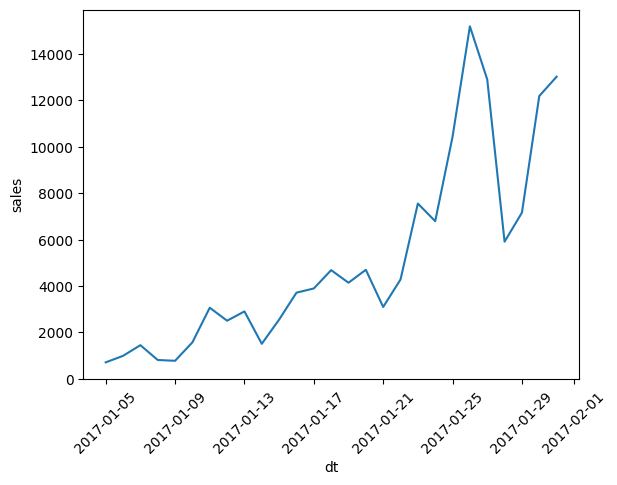

In [56]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.xticks(rotation=45)
sns.lineplot(
    data=df,
    x="dt",
    y="sales"
)

## 연습문제

1. 2018년 1월 일별 매출 추이를 그려보세요
2. 2018년 1월 결제 수단별 매출액의 추이를 비교해보세요.
3. 2017년 한 해동안 주간 매출액 추이를 그려보세요. YEARWEEK라는 SQL 문법을 사용해보세요.

### 1번

In [58]:
read_sql = """
SELECT
    DATE(olist_orders.order_purchase_timestamp) AS dt,
    SUM(olist_order_payments.payment_value) AS sales
FROM
    olist_orders
LEFT JOIN
    olist_order_payments
ON
    olist_order_payments.order_id=olist_orders.order_id
WHERE
    order_purchase_timestamp >= "2018-01-01"
    AND order_purchase_timestamp < "2018-02-01"
GROUP BY
    1
ORDER BY
    1
"""

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_76121/1875548506.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


<Axes: xlabel='dt', ylabel='sales'>

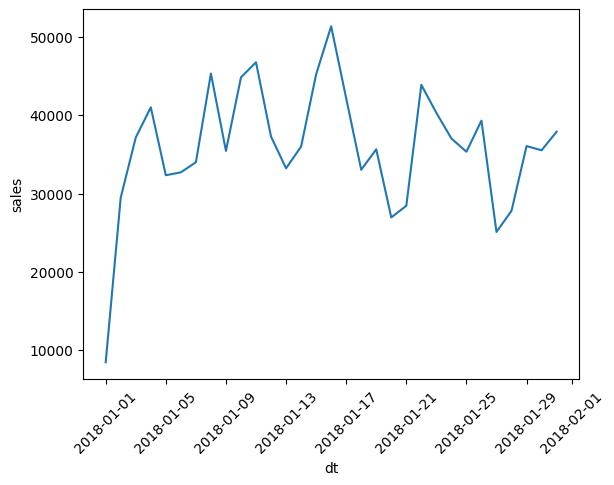

In [61]:
df = read_data(read_sql)
plt.xticks(rotation=45)
sns.lineplot(
    data=df,
    x="dt",
    y="sales"
)

### 2번

In [62]:
read_sql = """
SELECT
    DATE(olist_orders.order_purchase_timestamp) AS dt,
    olist_order_payments.payment_type,
    SUM(olist_order_payments.payment_value) AS sales
FROM
    olist_orders
LEFT JOIN
    olist_order_payments
ON
    olist_order_payments.order_id=olist_orders.order_id
WHERE
    order_purchase_timestamp >= "2018-01-01"
    AND order_purchase_timestamp < "2018-02-01"
GROUP BY
    1, 2
ORDER BY
    1, 2
"""

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_76121/1875548506.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


<Axes: xlabel='dt', ylabel='sales'>

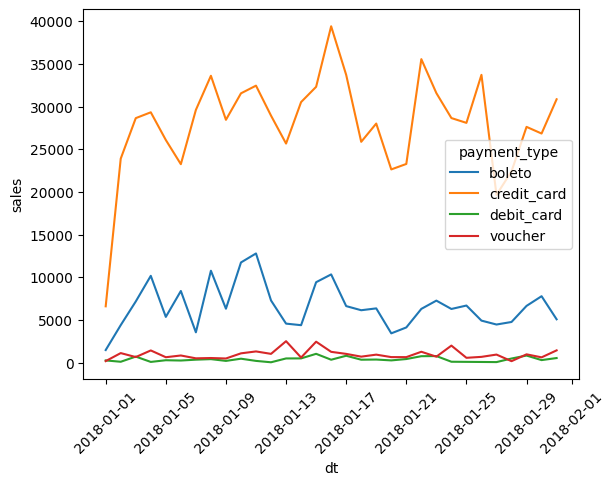

In [63]:
df = read_data(read_sql)
plt.xticks(rotation=45)
sns.lineplot(
    data=df,
    x="dt",
    y="sales",
    hue="payment_type"
)

### 3번

In [73]:
read_sql = """
SELECT
    YEARWEEK(olist_orders.order_purchase_timestamp) AS yearweek,
    SUM(olist_order_payments.payment_value) AS sales
FROM
    olist_orders
LEFT JOIN
    olist_order_payments
ON
    olist_order_payments.order_id=olist_orders.order_id
WHERE
    order_purchase_timestamp >= "2017-01-01"
    AND order_purchase_timestamp < "2018-01-01"
GROUP BY
    1
ORDER BY
    1
"""

In [74]:
df = read_data(read_sql)
df

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_76121/1875548506.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn)


,yearweek,sales
0,201701,3143.540036
1,201702,13131.660055
2,201703,26773.559998
3,201704,63068.990040
4,201705,80744.179697
5,201706,84873.049806
6,201707,78615.450042
7,201708,54042.829896
8,201709,87760.719952
9,201710,93780.509906


<Axes: xlabel='yearweek', ylabel='sales'>

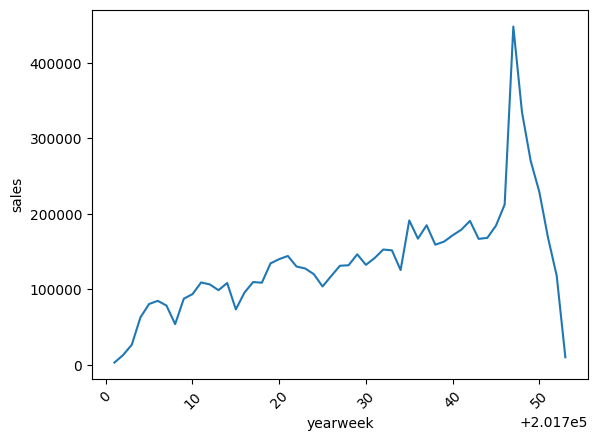

In [75]:
plt.xticks(rotation=45)
sns.lineplot(
    data=df,
    x="yearweek",
    y="sales",
)

## 정리

여기까지 데이터 저장, 분석, 시각화까지 작은 데이터 분석 프로젝트를 진행해봤습니다.  
어떤가요? 생각보다 할만하지 않으신가요?  
간단한 python과 SQL문 만으로도 꽤나 그럴듯한 분석을 할 수 있었습니다.  
지금까지 배운 내용을 잘 복습해서 본인 것으로 만들고, 세미 프로젝트 진행할 수 있으면 좋겠습니다.